# Looking at TCR data in all-cells object to mark non-T cells with BCR information as doublets

CVID, revisions

analysis with scirpy

02.2021: reanalysis of twin activation data after bertie bug correction

In [1]:
import scirpy as ir # requires 'pip install scirpy'
import scanpy as sc
from glob import glob
import pandas as pd
import numpy as np
import tarfile
import anndata
import warnings
from numba import NumbaPerformanceWarning

# ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.set_figure_params(dpi=100)


In [3]:
%%bash

pip freeze

aiohttp==3.6.2
airr==1.3.1
alembic==1.3.0
anndata==0.7.5
annoy==1.16.2
async-generator==1.10
async-timeout==3.0.1
attrs==19.3.0
backcall==0.1.0
bbknn==1.3.6
bleach==3.1.0
blinker==1.4
certifi==2019.9.11
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
Click==7.0
conda==4.7.12
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
Cython==0.29.14
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
fbpca==1.0
geosketch==1.0
get-version==2.1
h5py==2.10.0
idna==2.8
imageio==2.9.0
importlib-metadata==0.23
intervaltree==2.1.0
ipykernel==5.1.3
ipython==7.9.0
ipython-genutils==0.2.0
jedi==0.15.1
Jinja2==2.10.3
joblib==0.14.0
json5==0.8.5
jsonschema==3.1.1
jupyter-client==5.3.3
jupyter-core==4.5.0
jupyter-rsession-proxy==1.0b6
jupyter-server-proxy==1.2.0
jupyterhub==1.0.0
jupyterlab==1.2.1
jupyterlab-server==1.0.6
kiwisolver==1.1.0
legacy-api-wrap==1.2
leidenalg==0.7.0
llvmlite==0.30.0
loompy==3.0.6
louvain==0.6.1
Mako==1.1.0
MarkupSafe==1.1.1
matplotlib==3.3.4
mistune==0.8.4
more-itertools==

## Reading in the main transcriptomics object

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

In [6]:
# object with all cells, norm., log tr and scaled gex counts in .X, norm. and log tr. gex counts in .raw.X, HVG-subsetted
adata = sc.read(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs.h5ad')

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [7]:
adata

AnnData object with n_obs × n_vars = 17315 × 2439
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'activation_colors', 'ccgs', 'celltype_predictions_colors', 'condition_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Loading data from cellranger output

#### general scRNA-seq

Immunodeficiency8103070          CVID_CTRL_Bcells

Immunodeficiency8103072          CVID_CD40L_Bcells

Immunodeficiency8103073          CVID_CD3_Bcells

Immunodeficiency8103074          CONTROL_CTRL_Bcells

Immunodeficiency8103076          CONTROL_CD40L_Bcells

Immunodeficiency8103077          CONTROL_CD3_Bcells

#### TCR enriched

Immunodeficiency8103062          CVID_CTRL_Bcells_B

Immunodeficiency8103064          CVID_CD40L_Bcells_B

Immunodeficiency8103065          CVID_CD3_Bcells_B

Immunodeficiency8103066          CONTROL_CTRL_Bcells_B

Immunodeficiency8103068          CONTROL_CD40L_Bcells_B

Immunodeficiency8103069          CONTROL_CD3_Bcells_B

In [8]:
samples_enriched = ['Immunodeficiency8103062',
                    'Immunodeficiency8103064',
                    'Immunodeficiency8103065',
                    'Immunodeficiency8103066',
                    'Immunodeficiency8103068',
                    'Immunodeficiency8103069']

In [9]:
np.unique(adata.obs['sample'])

array(['Immunodeficiency8103070', 'Immunodeficiency8103072',
       'Immunodeficiency8103073', 'Immunodeficiency8103074',
       'Immunodeficiency8103076', 'Immunodeficiency8103077'], dtype=object)

In [10]:
dict_samples_enrich_to_general =  {}

# BCR

dict_samples_enrich_to_general['Immunodeficiency8103062'] = 'Immunodeficiency8103070'
dict_samples_enrich_to_general['Immunodeficiency8103064'] = 'Immunodeficiency8103072'
dict_samples_enrich_to_general['Immunodeficiency8103065'] = 'Immunodeficiency8103073'
dict_samples_enrich_to_general['Immunodeficiency8103066'] = 'Immunodeficiency8103074'
dict_samples_enrich_to_general['Immunodeficiency8103068'] = 'Immunodeficiency8103076'
dict_samples_enrich_to_general['Immunodeficiency8103069'] = 'Immunodeficiency8103077'

In [11]:
list(dict_samples_enrich_to_general.keys())[:1]

['Immunodeficiency8103062']

In [12]:
%%time

# Create a list of AnnData objects (one for each sample)
adatas_gex_with_tcr = {}
for sample_tcr, sample_gex in dict_samples_enrich_to_general.items():
    
    print('gex sample', sample_gex)
    print('TCR sample', sample_tcr)
    
    gex_path = '/home/jovyan/notebooks/Vento_Lab/CVID/activation_matrices/filtered_feature_bc_matrix_' + sample_gex + '.h5'
    tcr_path = '/lustre/scratch117/cellgen/team292/aa22/data/CVID_related/cellranger_vdj_CVID_activation/' + sample_tcr + '/filtered_contig_annotations.csv'
    
    print('reading files')
    
    adata_gex = sc.read_10x_h5(gex_path)
    # remembering the unique barcode_sample index
    adata_gex.obs['barcode_sample'] = [barcode + '_' + sample_gex for barcode in adata_gex.obs_names]
    adata_tcr = ir.io.read_10x_vdj(tcr_path)
    
    print('merging gex and BCR adatas')
    
    ir.pp.merge_with_ir(adata_gex, adata_tcr)
    
    print('done merging')
    
    # concatenation only works with unique gene names
    adata_gex.var_names_make_unique()
    adatas_gex_with_tcr[sample_gex] = adata_gex


gex sample Immunodeficiency8103070
TCR sample Immunodeficiency8103062
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_2_expr' as categorical
... storing 'IR_VDJ_2_expr' as categorical
... storing 'IR_VJ_2_expr_raw' as categorical
... storing 'IR_VDJ_2_expr_raw' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical


merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample Immunodeficiency8103072
TCR sample Immunodeficiency8103064
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_expr' as categorical
... storing 'IR_VJ_2_expr' as categorical
... storing 'IR_VDJ_2_expr' as categorical
... storing 'IR_VJ_1_expr_raw' as categorical
... storing 'IR_VJ_2_expr_raw' as categorical
... storing 'IR_VDJ_2_expr_raw' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'm

merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample Immunodeficiency8103073
TCR sample Immunodeficiency8103065
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical


merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


done merging
gex sample Immunodeficiency8103074
TCR sample Immunodeficiency8103066
reading files


... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical


merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


done merging
gex sample Immunodeficiency8103076
TCR sample Immunodeficiency8103068
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_2_expr' as categorical
... storing 'IR_VJ_2_expr_raw' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical


merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample Immunodeficiency8103077
TCR sample Immunodeficiency8103069
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_2_expr' as categorical
... storing 'IR_VDJ_2_expr' as categorical
... storing 'IR_VJ_2_expr_raw' as categorical
... storing 'IR_VDJ_2_expr_raw' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
CPU times: user 22.3 s, sys: 10.9 s, total: 33.2 s
Wall time: 33.5 s


In [13]:
# Merge anndata objects
adata_with_tcr = list(adatas_gex_with_tcr.values())[0].concatenate(list(adatas_gex_with_tcr.values())[1:])

In [14]:
adata_with_tcr

AnnData object with n_obs × n_vars = 19023 × 33694
    obs: 'barcode_sample', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [15]:
adata_with_tcr.obs

barcode_sample  \
AAACCTGCAGACAAGC-1-0  AAACCTGCAGACAAGC-1_Immunodeficiency8103070   
AAACCTGCATGTTCCC-1-0  AAACCTGCATGTTCCC-1_Immunodeficiency8103070   
AAACCTGGTCTCTCTG-1-0  AAACCTGGTCTCTCTG-1_Immunodeficiency8103070   
AAACCTGTCGAACTGT-1-0  AAACCTGTCGAACTGT-1_Immunodeficiency8103070   
AAACGGGAGATGAGAG-1-0  AAACGGGAGATGAGAG-1_Immunodeficiency8103070   
...                                                          ...   
TTTGTCACATGGTCAT-1-5  TTTGTCACATGGTCAT-1_Immunodeficiency8103077   
TTTGTCAGTAAATGTG-1-5  TTTGTCAGTAAATGTG-1_Immunodeficiency8103077   
TTTGTCAGTATCTGCA-1-5  TTTGTCAGTATCTGCA-1_Immunodeficiency8103077   
TTTGTCAGTCAATACC-1-5  TTTGTCAGTCAATACC-1_Immunodeficiency8103077   
TTTGTCAGTTGAACTC-1-5  TTTGTCAGTTGAACTC-1_Immunodeficiency8103077   

                     IR_VJ_1_locus IR_VJ_2_locus IR_VDJ_1_locus  \
AAACCTGCAGACAAGC-1-0           NaN           NaN            NaN   
AAACCTGCATGTTCCC-1-0           NaN           NaN            NaN   
AAACCTGGTCTCTCTG-1-0           NaN           NaN            NaN   
AAACCTGTCGAACTGT-1-0           NaN           NaN            NaN   
AAACGGGAGATGAGAG-1-0           NaN           NaN            NaN   
...                            ...           ...            ...   
TTTGTCACATGGTCAT-1-5           NaN           NaN            NaN   
TTTGTCAGTAAATGTG-1-5           NaN           NaN            NaN   
TTTGTCAGTATCTGCA-1-5           NaN           NaN            NaN   
TTTGTCAGTCAATACC-1-5           NaN           NaN            NaN   
TTTGTCAGTTGAACTC-1-5           NaN           NaN            NaN   

                     IR_VDJ_2_locus IR_VJ_1_cdr3 IR_VJ_2_cdr3 IR_VDJ_1_cdr3  \
AAACCTGCAGACAAGC-1-0            NaN          NaN          NaN           NaN   
AAACCTGCATGTTCCC-1-0            NaN          NaN          NaN           NaN   
AAACCTGGTCTCTCTG-1-0            NaN          NaN          NaN           NaN   
AAACCTGTCGAACTGT-1-0            NaN          NaN          NaN           NaN   
AAACGGGAGATGAGAG-1-0            NaN          NaN          NaN           NaN   
...                             ...          ...          ...           ...   
TTTGTCACATGGTCAT-1-5            NaN          NaN          NaN           NaN   
TTTGTCAGTAAATGTG-1-5            NaN          NaN          NaN           NaN   
TTTGTCAGTATCTGCA-1-5            NaN          NaN          NaN           NaN   
TTTGTCAGTCAATACC-1-5            NaN          NaN          NaN           NaN   
TTTGTCAGTTGAACTC-1-5            NaN          NaN          NaN           NaN   

                     IR_VDJ_2_cdr3 IR_VJ_1_cdr3_nt  ... IR_VJ_2_c_gene  \
AAACCTGCAGACAAGC-1-0           NaN             NaN  ...            NaN   
AAACCTGCATGTTCCC-1-0           NaN             NaN  ...            NaN   
AAACCTGGTCTCTCTG-1-0           NaN             NaN  ...            NaN   
AAACCTGTCGAACTGT-1-0           NaN             NaN  ...            NaN   
AAACGGGAGATGAGAG-1-0           NaN             NaN  ...            NaN   
...                            ...             ...  ...            ...   
TTTGTCACATGGTCAT-1-5           NaN             NaN  ...            NaN   
TTTGTCAGTAAATGTG-1-5           NaN             NaN  ...            NaN   
TTTGTCAGTATCTGCA-1-5           NaN             NaN  ...            NaN   
TTTGTCAGTCAATACC-1-5           NaN             NaN  ...            NaN   
TTTGTCAGTTGAACTC-1-5           NaN             NaN  ...            NaN   

                     IR_VDJ_1_c_gene IR_VDJ_2_c_gene IR_VJ_1_junction_ins  \
AAACCTGCAGACAAGC-1-0             NaN             NaN                  NaN   
AAACCTGCATGTTCCC-1-0             NaN             NaN                  NaN   
AAACCTGGTCTCTCTG-1-0             NaN             NaN                  NaN   
AAACCTGTCGAACTGT-1-0             NaN             NaN                  NaN   
AAACGGGAGATGAGAG-1-0             NaN             NaN                  NaN   
...                              ...             ...                  ...   
TTTGTCACATGGTCAT-1-5             NaN             Na

In [16]:
TCR_table = adata_with_tcr.obs.set_index('barcode_sample', drop=True)

In [17]:
TCR_table

IR_VJ_1_locus IR_VJ_2_locus  \
barcode_sample                                                           
AAACCTGCAGACAAGC-1_Immunodeficiency8103070           NaN           NaN   
AAACCTGCATGTTCCC-1_Immunodeficiency8103070           NaN           NaN   
AAACCTGGTCTCTCTG-1_Immunodeficiency8103070           NaN           NaN   
AAACCTGTCGAACTGT-1_Immunodeficiency8103070           NaN           NaN   
AAACGGGAGATGAGAG-1_Immunodeficiency8103070           NaN           NaN   
...                                                  ...           ...   
TTTGTCACATGGTCAT-1_Immunodeficiency8103077           NaN           NaN   
TTTGTCAGTAAATGTG-1_Immunodeficiency8103077           NaN           NaN   
TTTGTCAGTATCTGCA-1_Immunodeficiency8103077           NaN           NaN   
TTTGTCAGTCAATACC-1_Immunodeficiency8103077           NaN           NaN   
TTTGTCAGTTGAACTC-1_Immunodeficiency8103077           NaN           NaN   

                                           IR_VDJ_1_locus IR_VDJ_2_locus  \
barcode_sample                                                             
AAACCTGCAGACAAGC-1_Immunodeficiency8103070            NaN            NaN   
AAACCTGCATGTTCCC-1_Immunodeficiency8103070            NaN            NaN   
AAACCTGGTCTCTCTG-1_Immunodeficiency8103070            NaN            NaN   
AAACCTGTCGAACTGT-1_Immunodeficiency8103070            NaN            NaN   
AAACGGGAGATGAGAG-1_Immunodeficiency8103070            NaN            NaN   
...                                                   ...            ...   
TTTGTCACATGGTCAT-1_Immunodeficiency8103077            NaN            NaN   
TTTGTCAGTAAATGTG-1_Immunodeficiency8103077            NaN            NaN   
TTTGTCAGTATCTGCA-1_Immunodeficiency8103077            NaN            NaN   
TTTGTCAGTCAATACC-1_Immunodeficiency8103077            NaN            NaN   
TTTGTCAGTTGAACTC-1_Immunodeficiency8103077            NaN            NaN   

                                           IR_VJ_1_cdr3 IR_VJ_2_cdr3  \
barcode_sample                                                         
AAACCTGCAGACAAGC-1_Immunodeficiency8103070          NaN          NaN   
AAACCTGCATGTTCCC-1_Immunodeficiency8103070          NaN          NaN   
AAACCTGGTCTCTCTG-1_Immunodeficiency8103070          NaN          NaN   
AAACCTGTCGAACTGT-1_Immunodeficiency8103070          NaN          NaN   
AAACGGGAGATGAGAG-1_Immunodeficiency8103070          NaN          NaN   
...                                                 ...          ...   
TTTGTCACATGGTCAT-1_Immunodeficiency8103077          NaN          NaN   
TTTGTCAGTAAATGTG-1_Immunodeficiency8103077          NaN          NaN   
TTTGTCAGTATCTGCA-1_Immunodeficiency8103077          NaN          NaN   
TTTGTCAGTCAATACC-1_Immunodeficiency8103077          NaN          NaN   
TTTGTCAGTTGAACTC-1_Immunodeficiency8103077          NaN          NaN   

                                           IR_VDJ_1_cdr3 IR_VDJ_2_cdr3  \
barcode_sample                                                           
AAACCTGCAGACAAGC-1_Immunodeficiency8103070           NaN           NaN   
AAACCTGCATGTTCCC-1_Immunodeficiency8103070           NaN           NaN   
AAACCTGGTCTCTCTG-1_Immunodeficiency8103070           NaN           NaN   
AAACCTGTCGAACTGT-1_Immunodeficiency8103070           NaN           NaN   
AAACGGGAGATGAGAG-1_Immunodeficiency8103070           NaN           NaN   
...                                                  ...           ...   
TTTGTCACATGGTCAT-1_Immunodeficiency8103077           NaN           NaN   
TTTGTCAGTAAATGTG-1_Immunodeficiency8103077           NaN           NaN   
TTTGTCAGTATCTGCA-1_Immunodeficiency8103077           NaN           NaN   
TTTGTCAGTCAATACC-1_Immunodeficiency8103077           NaN           NaN   
TTTGTCAGTTGAACTC-1_Immunodeficiency8103077           NaN           NaN   

                                           IR_VJ_1_cdr3_nt IR_VJ_2_cdr3_nt  \
barcode_sample                                                               
AAACCTGCAGACAAGC-1_Immunodeficiency

In [18]:
# adding all the BCR info to the final adata object .obs table

def add_TCR_info(adata_obj, barcode_sample, column):
    
    if barcode_sample in TCR_table.index:
        value = TCR_table.loc[barcode_sample, column]
        return(value)
    else:
        return('none')

In [20]:
%%time

# adding BCR data to adata.obs table

for col in TCR_table.columns:
    print(col)
    adata.obs[col] = adata.obs['barcode_sample'].apply(lambda x: add_TCR_info(adata, x, column=col))

IR_VJ_1_locus
IR_VJ_2_locus
IR_VDJ_1_locus
IR_VDJ_2_locus
IR_VJ_1_cdr3
IR_VJ_2_cdr3
IR_VDJ_1_cdr3
IR_VDJ_2_cdr3
IR_VJ_1_cdr3_nt
IR_VJ_2_cdr3_nt
IR_VDJ_1_cdr3_nt
IR_VDJ_2_cdr3_nt
IR_VJ_1_expr
IR_VJ_2_expr
IR_VDJ_1_expr
IR_VDJ_2_expr
IR_VJ_1_expr_raw
IR_VJ_2_expr_raw
IR_VDJ_1_expr_raw
IR_VDJ_2_expr_raw
IR_VJ_1_v_gene
IR_VJ_2_v_gene
IR_VDJ_1_v_gene
IR_VDJ_2_v_gene
IR_VJ_1_d_gene
IR_VJ_2_d_gene
IR_VDJ_1_d_gene
IR_VDJ_2_d_gene
IR_VJ_1_j_gene
IR_VJ_2_j_gene
IR_VDJ_1_j_gene
IR_VDJ_2_j_gene
IR_VJ_1_c_gene
IR_VJ_2_c_gene
IR_VDJ_1_c_gene
IR_VDJ_2_c_gene
IR_VJ_1_junction_ins
IR_VJ_2_junction_ins
IR_VDJ_1_junction_ins
IR_VDJ_2_junction_ins
has_ir
multi_chain
batch
CPU times: user 5.88 s, sys: 0 ns, total: 5.88 s
Wall time: 5.88 s


In [21]:
ir.tl.chain_qc(adata)


In [22]:
adata

AnnData object with n_obs × n_vars = 17315 × 2439
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junc

... storing 'batch' as categorical
... storing 'IR_VJ_1_locus' as categorical
... storing 'IR_VDJ_1_locus' as categorical
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_expr' as categorical
... storing 'IR_VJ_2_expr' as categorical
... storing 'IR_VDJ_2_expr' as categorical
... storing 'IR_VJ_1_expr_raw' as categorical
... storing 'IR_VJ_2_expr_raw' as categorical
... storing 'IR_VDJ_2_expr_raw' as categorical
... storing 'IR_VJ_1_v_gene' as categorical
... storing 'IR_VDJ_1_v_gene' as categorical
... storing 'IR_VJ_1_d_gene' as categorical
... storing 'IR_VDJ_1_d_gene' as categorical
... storing 'IR_VJ_1_j_gene' as categorical
... storing 'IR_VDJ_1_j_gene' as categ

<AxesSubplot:title={'center':'Number of cells in receptor_subtype by activation'}, xlabel='receptor_subtype', ylabel='Number of cells'>

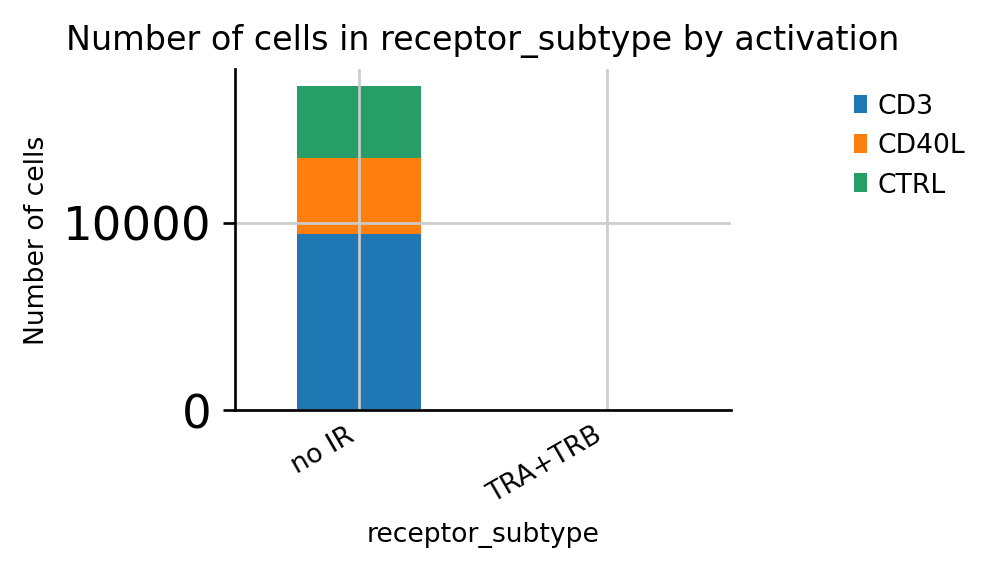

In [23]:
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="activation")


<AxesSubplot:title={'center':'Number of cells in receptor_subtype by condition'}, xlabel='receptor_subtype', ylabel='Number of cells'>

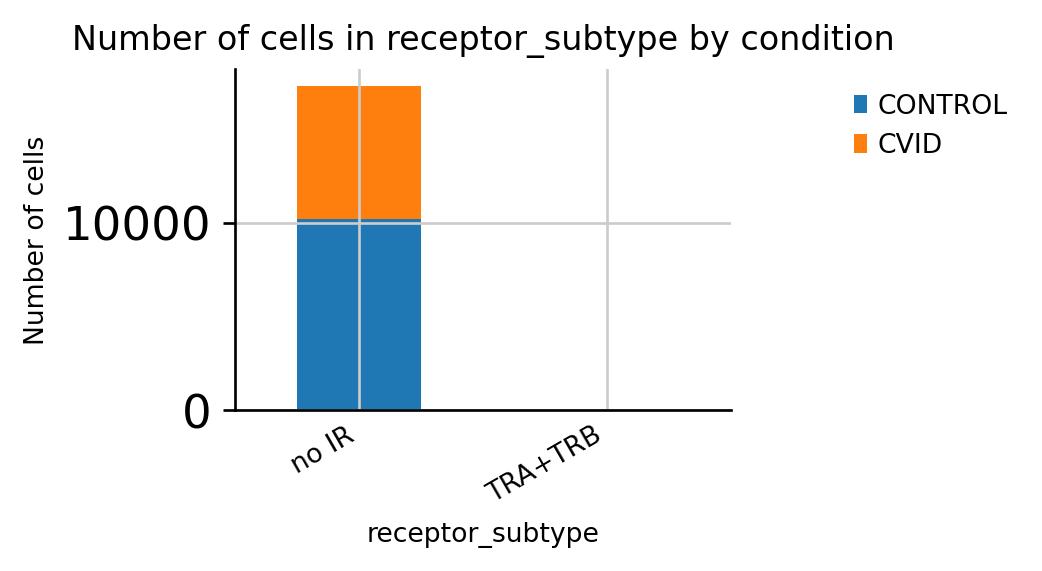

In [24]:
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="condition")


In [25]:
adata

AnnData object with n_obs × n_vars = 17315 × 2439
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junc

In [26]:
adata.obs['louvain'] = adata.obs['louvain'].astype(str)

... storing 'louvain' as categorical


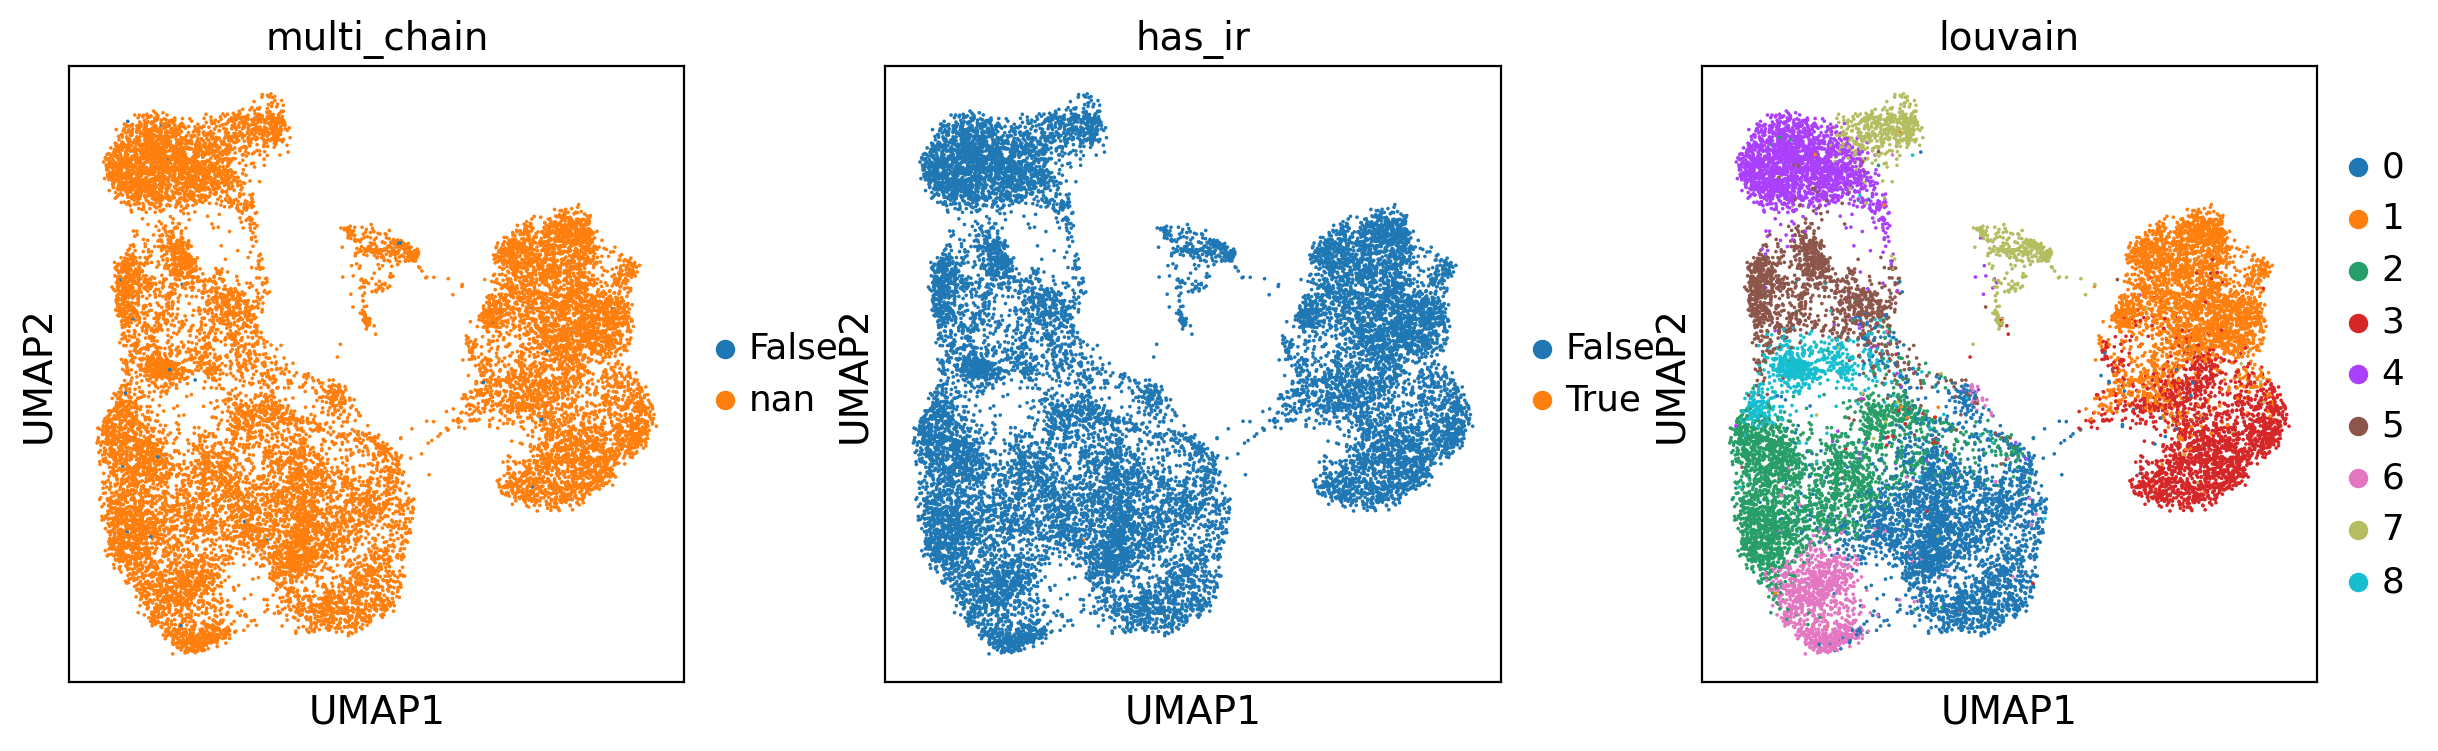

In [27]:
sc.pl.umap(adata, color=['multi_chain','has_ir','louvain'])


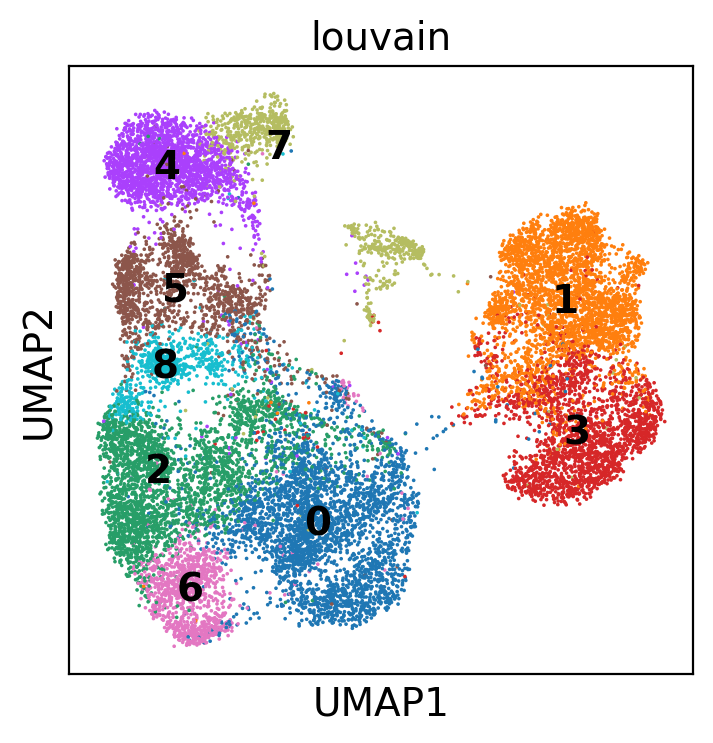

In [30]:
sc.pl.umap(adata, color=['louvain'], legend_loc='on data')


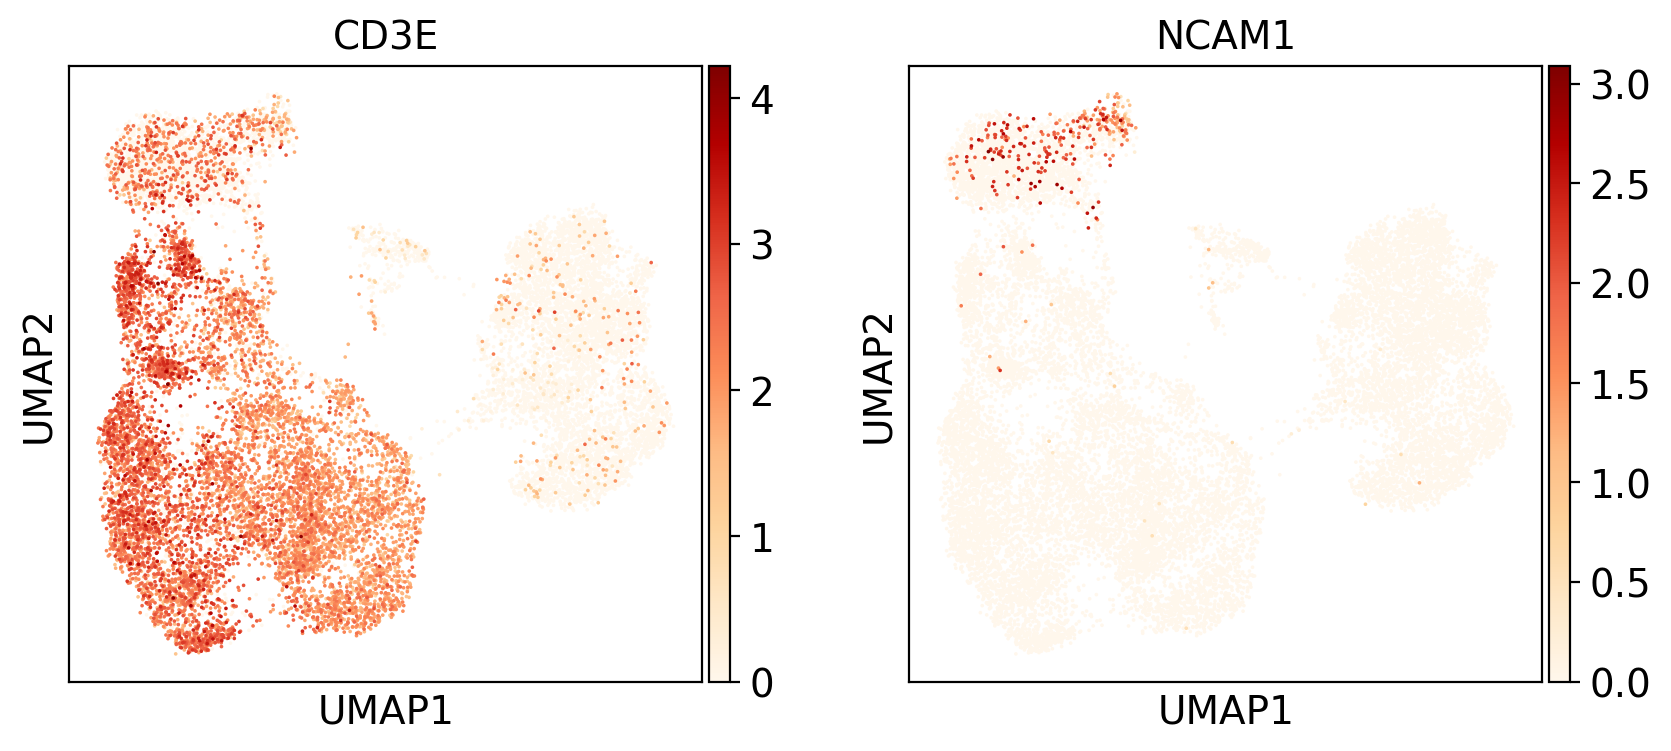

In [29]:
sc.pl.umap(adata, color=['CD3E','NCAM1'], cmap='OrRd', use_raw=True)


In [31]:
# reading preliminary annotation to know which cells are T cells
#annot_table = pd.read_csv(save_path + 'annotation_of_adata_hvg_BBKNN_GEX_and_SoupX_denoised_protein_all_samples_20210108.csv',
#                         index_col=0)

In [32]:
# T cell clusters: 0, 2, 5, 6, 8

In [33]:
np.unique(adata.obs['has_ir'], return_counts=True)

(array(['False', 'True'], dtype=object), array([17313,     2]))

# OK so something went wrong here - there is almost no TCR data at all, not marking any doublets here or analysing this data further

In [72]:
adata.obs['barcode']

AAACCTGAGAATGTGT-1        AAACCTGAGAATGTGT-1
AAACCTGAGACTAAGT-1        AAACCTGAGACTAAGT-1
AAACCTGAGCCGCCTA-1        AAACCTGAGCCGCCTA-1
AAACCTGAGCGCCTCA-1        AAACCTGAGCGCCTCA-1
AAACCTGAGGATGTAT-1        AAACCTGAGGATGTAT-1
                                ...         
TTTGTCATCGCCTGAG-1        TTTGTCATCGCCTGAG-1
TTTGTCATCGTCACGG-1-1    TTTGTCATCGTCACGG-1-1
TTTGTCATCGTCTGCT-1-1    TTTGTCATCGTCTGCT-1-1
TTTGTCATCTACTTAC-1        TTTGTCATCTACTTAC-1
TTTGTCATCTCTTATG-1        TTTGTCATCTCTTATG-1
Name: barcode, Length: 163320, dtype: object

In [73]:
adata.obs['doublets_by_TCR'] = adata.obs['barcode'].apply(lambda x: mark_doublets_by_TCR(adata,x))

In [74]:
np.unique(adata.obs['doublets_by_TCR'], return_counts=True)

(array(['False', 'True'], dtype=object), array([149897,  13423]))

... storing 'doublets_by_TCR' as categorical


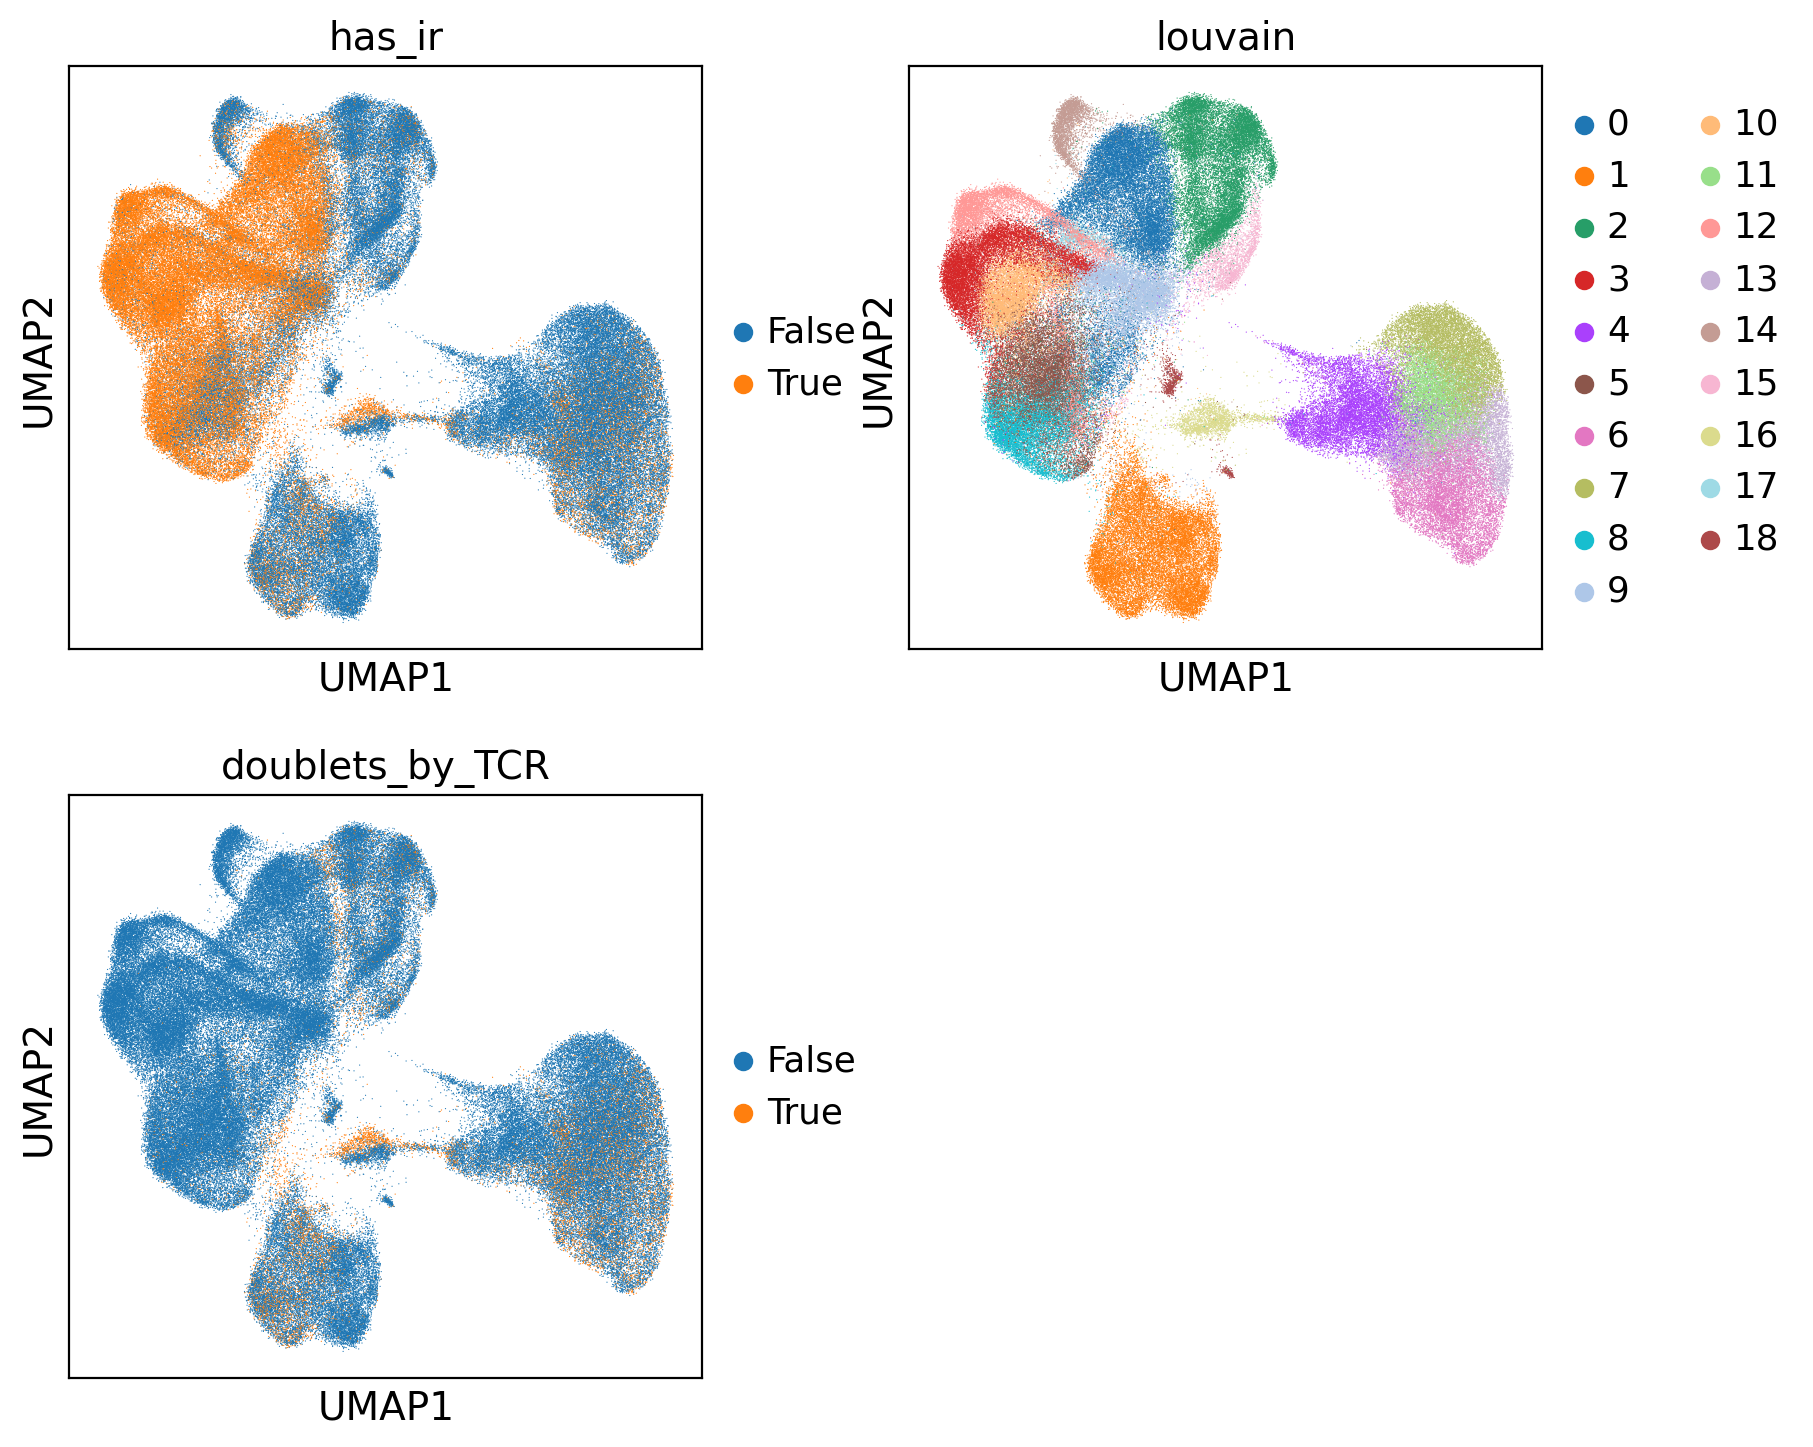

In [75]:
# any BCR data outside B cells (louvain cluster 1)?
sc.pl.umap(adata, color=['has_ir','louvain','doublets_by_TCR'], 
           cmap='OrRd', ncols=2)


In [76]:
adata.obs.loc[:,'doublets_by_TCR']

AAACCTGAGAATGTGT-1      False
AAACCTGAGACTAAGT-1      False
AAACCTGAGCCGCCTA-1      False
AAACCTGAGCGCCTCA-1      False
AAACCTGAGGATGTAT-1      False
                        ...  
TTTGTCATCGCCTGAG-1       True
TTTGTCATCGTCACGG-1-1    False
TTTGTCATCGTCTGCT-1-1    False
TTTGTCATCTACTTAC-1      False
TTTGTCATCTCTTATG-1      False
Name: doublets_by_TCR, Length: 163320, dtype: category
Categories (2, object): ['False', 'True']

In [77]:
doublets_by_TCR = pd.DataFrame(adata.obs.loc[:,'doublets_by_TCR'])

In [78]:
doublets_by_TCR

doublets_by_TCR
AAACCTGAGAATGTGT-1             False
AAACCTGAGACTAAGT-1             False
AAACCTGAGCCGCCTA-1             False
AAACCTGAGCGCCTCA-1             False
AAACCTGAGGATGTAT-1             False
...                              ...
TTTGTCATCGCCTGAG-1              True
TTTGTCATCGTCACGG-1-1           False
TTTGTCATCGTCTGCT-1-1           False
TTTGTCATCTACTTAC-1             False
TTTGTCATCTCTTATG-1             False

[163320 rows x 1 columns]

In [79]:
np.unique(doublets_by_TCR['doublets_by_TCR'], return_counts=True)

(array(['False', 'True'], dtype=object), array([149897,  13423]))

In [81]:
doublets_by_TCR.to_csv(save_path + 'doublets_by_TCR_table_20210106.csv')